## Toxic comment classification
### Import library

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import sparse
%matplotlib inline
seed = 42
import os
os.environ['OMP_NUM_THREADS'] = '4'


## Read data set

In [5]:
#path = 'file/'
train = pd.read_csv('toxicity_data/train.csv')
test = pd.read_csv('toxicity_data/test.csv')
print('Number of rows and columns in the train data set:',train.shape)
print('Number of rows and columns in the test data set:',test.shape)

Number of rows and columns in the train data set: (159571, 8)
Number of rows and columns in the test data set: (153164, 2)


In [6]:
raw_train = train

In [7]:
train = train.sample(5000)
#train[train['toxic']==1].values[:5]

In [8]:
raw_test = test

In [9]:
test = test.sample(5000)

## Target varaible distribution

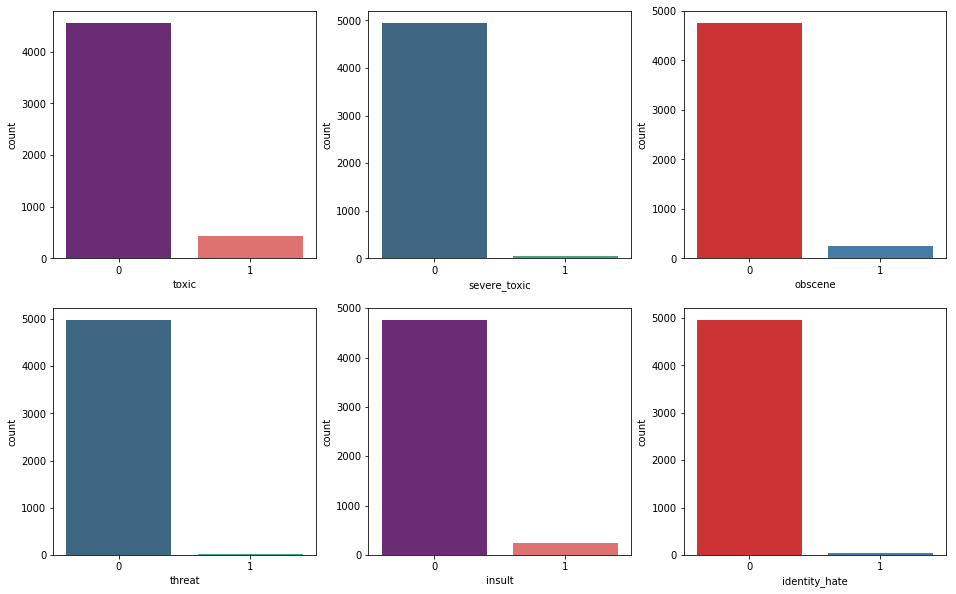

In [10]:
fig,ax = plt.subplots(2,3,figsize=(16,10))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
sns.countplot(train['toxic'],palette= 'magma',ax=ax1)
sns.countplot(train['severe_toxic'], palette= 'viridis',ax=ax2)
sns.countplot(train['obscene'], palette= 'Set1',ax=ax3)
sns.countplot(train['threat'], palette= 'viridis',ax = ax4)
sns.countplot(train['insult'], palette = 'magma',ax=ax5)
sns.countplot(train['identity_hate'], palette = 'Set1', ax = ax6);

## Missing value

In [11]:
k = pd.DataFrame()
k['train'] = train.isnull().sum()
k['test'] = test.isnull().sum()
k

,train,test
id,0,0.0
comment_text,0,0.0
toxic,0,NaN
severe_toxic,0,NaN
obscene,0,NaN
threat,0,NaN
insult,0,NaN
identity_hate,0,NaN


In [12]:
train[train['insult']==1].sample(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
43801,74e8643075586e2c,Miners Day \n\nThanks for deleting it fuck bag...,1,0,1,1,1,0
39044,682d322fbafdc0dd,Everybody lock ur dicks cuz theyre gay!!!,1,0,1,0,1,1
118439,78cc7ccedaf6597f,"Bit Stupid, I can change my ip address wheneve...",1,0,0,0,1,0
87900,eb1e8df05d0213b4,Coward\n\nYou are a coward. By locking the Swi...,1,0,0,0,1,0
80114,d659ccc573f6e868,GO AHEAD FRANKIE ASS! AHAHAHAHAHAHAHAHAHAHAHA!,1,0,1,0,1,0
2179,05e7f830a1eb0a13,You\nYou're a little bitch. You can't handle a...,1,0,1,0,1,0
69602,ba2a6e0032d62a9e,"Ignore this idiot, this guy doesn't know anyth...",1,0,0,0,1,0
141337,f4277cd50a76c909,"Hey \nFuck you, you Russia-loving cunt.",1,0,1,0,1,1
87841,eafbde2827d823d2,"giving out someones personal information, and ...",1,0,1,0,1,0
123787,96161f91a504b650,"Fuck off \n\nQuit deleting my comments, read t...",1,0,1,0,1,0


In [13]:
test[test['comment_text'].isnull()]

,id,comment_text


In [11]:
test.fillna(' ',inplace=True)
gc.collect()

21